In [1]:
!pip install lime


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install shap


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
import time
from lime import lime_image
import shap
from skimage.segmentation import mark_boundaries

2025-05-03 20:17:58.448202: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 20:17:58.476339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746292678.505632    2670 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746292678.513687    2670 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 20:17:58.546281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ninadaithal/imagesoasis")

print("Path to dataset files:", path)

Path to dataset files: /home/helal/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1
Path to dataset files: /home/helal/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1


In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
# Set random seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Constants
DATA_DIR = path+"/Data"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_CLASSES = 4

# Enable mixed precision training for faster performance (if GPU supports it)
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [7]:
# Load and prepare data more efficiently
def load_data(data_dir):
    file_paths = []
    labels = []

    for class_name in sorted(os.listdir(data_dir)):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            # Use list comprehension for faster file loading
            class_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            file_paths.extend(class_files)
            labels.extend([class_name] * len(class_files))

    return pd.DataFrame({'file_path': file_paths, 'label': labels})

In [8]:
# Load data
df = load_data(DATA_DIR)

In [9]:
# Split data with stratification
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=SEED)

In [10]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights))

In [11]:
# Optimized data generators with caching and prefetching
def create_datagen(train=True):
    if train:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)
    return datagen

In [12]:
train_datagen = create_datagen(train=True)
val_datagen = create_datagen(train=False)
test_datagen = create_datagen(train=False)

In [13]:
# Create data generators with optimized settings
def create_generator(datagen, df, shuffle=False):
    generator = datagen.flow_from_dataframe(
        df,
        x_col='file_path',
        y_col='label',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle,
        seed=SEED
    )
    return generator

In [14]:
train_generator = create_generator(train_datagen, train_df, shuffle=True)
val_generator = create_generator(val_datagen, val_df)
test_generator = create_generator(test_datagen, test_df)

Found 55319 validated image filenames belonging to 4 classes.
Found 13830 validated image filenames belonging to 4 classes.
Found 17288 validated image filenames belonging to 4 classes.


In [15]:
# Build a more efficient model architecture
def build_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        # Entry block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Top layers
        layers.GlobalAveragePooling2D(),  # More efficient than Flatten + Dense
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Output layer as float32
    ])

    return model

In [16]:
model = build_model()

/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746292683.673205    2670 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [17]:
# Compile with optimized settings
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [18]:
# Callbacks for better training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [19]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [21]:
# Training with timing
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1746292690.189429    2759 service.cc:148] XLA service 0x7fd218015d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746292690.189567    2759 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-05-03 20:18:10.280645: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746292690.910458    2759 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-03 20:18:17.594904: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.000107304s
Trying algorithm eng19{k2=4} for conv (f16[64,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,112,112,32]{3,2,1,0}, f16[64,112,112,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"a

865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.5489 - auc: 0.7856 - loss: 1.2966 - precision: 0.8068 - recall: 0.3542

2025-05-03 20:27:09.133634: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_242', 4 bytes spill stores, 4 bytes spill loads

2025-05-03 20:27:09.615724: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_242', 12 bytes spill stores, 12 bytes spill loads

2025-05-03 20:27:35.732448: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_242', 4 bytes spill stores, 4 bytes spill loads

2025-05-03 20:27:35.759072: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_242', 12 bytes spill stores, 12 bytes spill loads



865/865 ━━━━━━━━━━━━━━━━━━━━ 571s 630ms/step - accuracy: 0.5489 - auc: 0.7856 - loss: 1.2965 - precision: 0.8069 - recall: 0.3543 - val_accuracy: 0.7777 - val_auc: 0.8524 - val_loss: 2.8736 - val_precision: 0.7777 - val_recall: 0.7777 - learning_rate: 0.0010
Epoch 2/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6030 - auc: 0.8411 - loss: 1.1420 - precision: 0.8513 - recall: 0.4786

865/865 ━━━━━━━━━━━━━━━━━━━━ 509s 588ms/step - accuracy: 0.6030 - auc: 0.8411 - loss: 1.1420 - precision: 0.8513 - recall: 0.4786 - val_accuracy: 0.7781 - val_auc: 0.8846 - val_loss: 1.6956 - val_precision: 0.7780 - val_recall: 0.7779 - learning_rate: 0.0010
Epoch 3/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6266 - auc: 0.8603 - loss: 1.0492 - precision: 0.8259 - recall: 0.5096

865/865 ━━━━━━━━━━━━━━━━━━━━ 475s 549ms/step - accuracy: 0.6266 - auc: 0.8604 - loss: 1.0492 - precision: 0.8259 - recall: 0.5096 - val_accuracy: 0.4117 - val_auc: 0.7092 - val_loss: 1.3687 - val_precision: 0.4316 - val_recall: 0.3568 - learning_rate: 0.0010
Epoch 4/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6550 - auc: 0.8861 - loss: 0.9279 - precision: 0.8002 - recall: 0.5603

865/865 ━━━━━━━━━━━━━━━━━━━━ 476s 550ms/step - accuracy: 0.6550 - auc: 0.8861 - loss: 0.9279 - precision: 0.8002 - recall: 0.5603 - val_accuracy: 0.6175 - val_auc: 0.8696 - val_loss: 0.9936 - val_precision: 0.6540 - val_recall: 0.5846 - learning_rate: 0.0010
Epoch 5/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.6682 - auc: 0.9010 - loss: 0.8168 - precision: 0.7747 - recall: 0.6001

865/865 ━━━━━━━━━━━━━━━━━━━━ 478s 552ms/step - accuracy: 0.6682 - auc: 0.9010 - loss: 0.8167 - precision: 0.7747 - recall: 0.6001 - val_accuracy: 0.6289 - val_auc: 0.8748 - val_loss: 0.9732 - val_precision: 0.6560 - val_recall: 0.5911 - learning_rate: 0.0010

Training completed in 2510.00 seconds


In [22]:
# Evaluation
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

270/271 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6285 - auc: 0.8750 - loss: 0.9674 - precision: 0.6550 - recall: 0.5908

2025-05-03 21:00:26.057564: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_242', 4 bytes spill stores, 4 bytes spill loads

2025-05-03 21:00:26.172876: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_242', 12 bytes spill stores, 12 bytes spill loads



271/271 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.6285 - auc: 0.8750 - loss: 0.9675 - precision: 0.6550 - recall: 0.5908

Test Accuracy: 62.49%
Test Loss: 0.9728
Test AUC: 0.8745
Test Precision: 0.6537
Test Recall: 0.5898


In [23]:
# Predictions
y_pred = model.predict(test_generator).argmax(axis=1)
y_true = test_generator.classes
y_probs = model.predict(test_generator)  # For ROC curve

271/271 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step


In [24]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred,
                           target_names=list(test_generator.class_indices.keys())))


Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       0.14      0.98      0.25      1000
 Moderate Dementia       0.34      0.24      0.29        98
      Non Demented       0.96      0.71      0.82     13445
Very mild Dementia       0.52      0.07      0.12      2745

          accuracy                           0.62     17288
         macro avg       0.49      0.50      0.37     17288
      weighted avg       0.84      0.62      0.67     17288



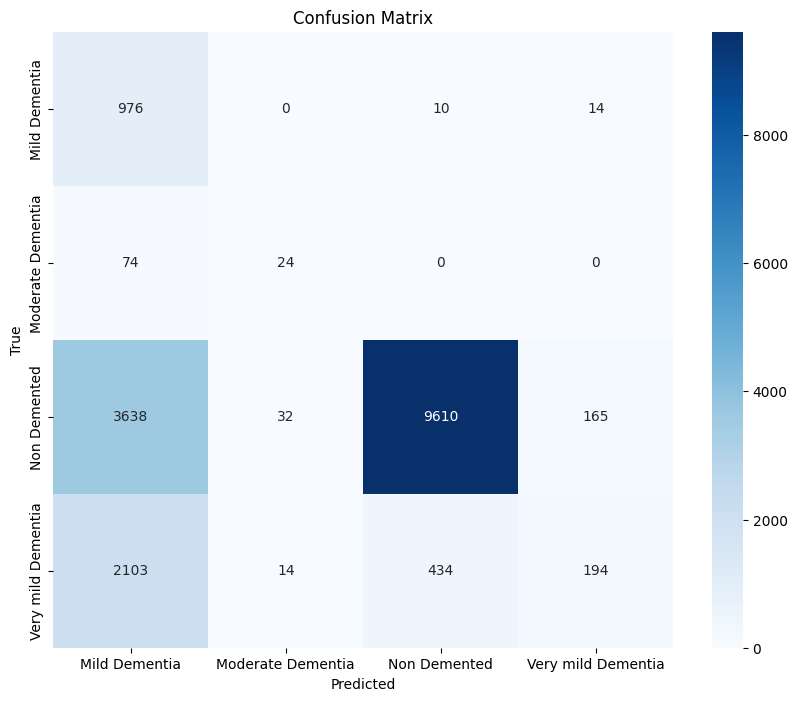

In [25]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, list(test_generator.class_indices.keys()))

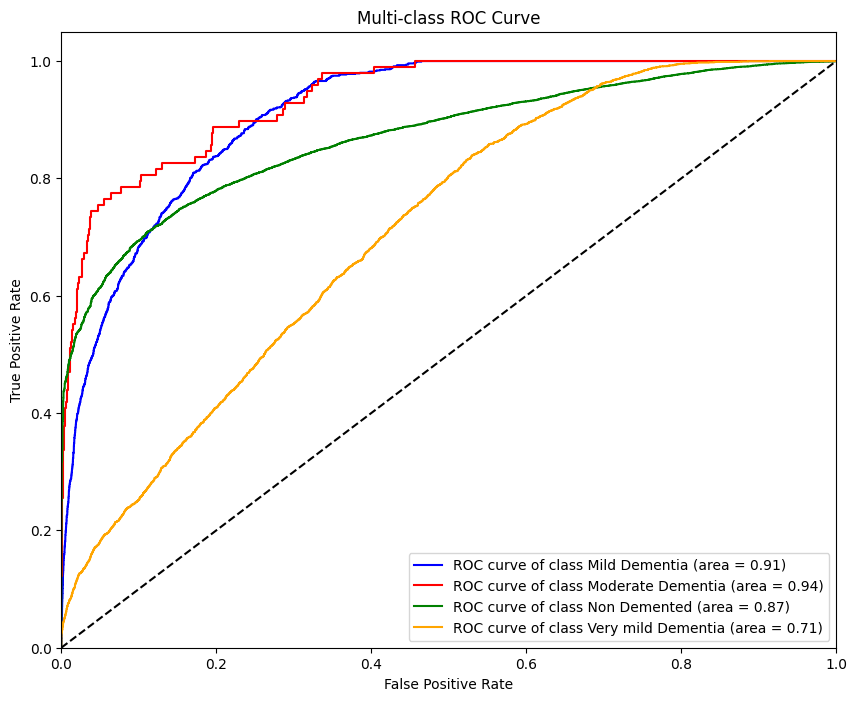

In [26]:
# ROC Curve
def plot_roc_curve(y_true, y_probs, classes):
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange']
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_true, y_probs, list(test_generator.class_indices.keys()))

  0%|                                                                                  | 0/1000 [00:00<?, ?it/s]2025-05-03 21:01:13.330019: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_167', 4 bytes spill stores, 4 bytes spill loads

2025-05-03 21:01:13.494877: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_167', 12 bytes spill stores, 12 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  1%|▋                                                                        | 10/1000 [00:02<03:30,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  2%|█▍                                                                       | 20/1000 [00:02<01:33, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|██▏                                                                      | 30/1000 [00:02<00:55, 17.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  4%|██▉                                                                      | 40/1000 [00:02<00:38, 25.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|███▋                                                                     | 50/1000 [00:02<00:28, 33.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|████▍                                                                    | 60/1000 [00:02<00:21, 43.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|█████                                                                    | 70/1000 [00:02<00:17, 52.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|█████▊                                                                   | 80/1000 [00:02<00:15, 60.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|██████▌                                                                  | 90/1000 [00:03<00:13, 68.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|███████▏                                                                | 100/1000 [00:03<00:11, 75.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|███████▉                                                                | 110/1000 [00:03<00:11, 80.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|████████▋                                                               | 120/1000 [00:03<00:10, 85.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 13%|█████████▎                                                              | 130/1000 [00:03<00:10, 86.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|██████████▏                                                             | 142/1000 [00:03<00:08, 95.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|███████████▏                                                           | 158/1000 [00:03<00:07, 112.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|████████████▏                                                           | 170/1000 [00:03<00:08, 93.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█████████████                                                           | 181/1000 [00:03<00:08, 97.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█████████████▋                                                         | 193/1000 [00:04<00:07, 103.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██████████████▌                                                        | 205/1000 [00:04<00:07, 107.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|███████████████▍                                                       | 217/1000 [00:04<00:07, 111.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|████████████████▌                                                       | 230/1000 [00:04<00:08, 95.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|█████████████████▎                                                      | 241/1000 [00:04<00:07, 97.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██████████████████▏                                                     | 252/1000 [00:04<00:07, 99.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██████████████████▉                                                     | 263/1000 [00:04<00:07, 97.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|███████████████████▋                                                    | 274/1000 [00:04<00:07, 99.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|████████████████████▌                                                   | 285/1000 [00:04<00:07, 98.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|█████████████████████                                                  | 296/1000 [00:05<00:07, 100.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|█████████████████████▊                                                 | 307/1000 [00:05<00:06, 101.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|██████████████████████▌                                                | 318/1000 [00:05<00:06, 102.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███████████████████████▎                                               | 329/1000 [00:05<00:06, 103.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|████████████████████████▍                                               | 340/1000 [00:05<00:07, 84.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|█████████████████████████▏                                              | 350/1000 [00:05<00:07, 87.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|█████████████████████████▉                                              | 360/1000 [00:05<00:07, 89.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|██████████████████████████▋                                             | 370/1000 [00:05<00:06, 90.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███████████████████████████▎                                            | 380/1000 [00:06<00:06, 91.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|████████████████████████████                                            | 390/1000 [00:06<00:06, 90.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████████████████████████████▊                                           | 400/1000 [00:06<00:06, 88.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|█████████████████████████████▌                                          | 410/1000 [00:06<00:06, 87.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|██████████████████████████████▏                                         | 420/1000 [00:06<00:06, 88.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|██████████████████████████████▉                                         | 430/1000 [00:06<00:06, 89.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|███████████████████████████████▋                                        | 440/1000 [00:06<00:06, 90.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████████████████████████████████▍                                       | 450/1000 [00:06<00:05, 92.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|█████████████████████████████████                                       | 460/1000 [00:06<00:06, 82.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|█████████████████████████████████▊                                      | 470/1000 [00:07<00:06, 85.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|██████████████████████████████████▊                                     | 483/1000 [00:07<00:05, 97.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|███████████████████████████████████▍                                    | 493/1000 [00:07<00:05, 97.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|████████████████████████████████████▏                                  | 509/1000 [00:07<00:04, 114.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████████████████████████████████████▌                                  | 521/1000 [00:07<00:05, 94.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|██████████████████████████████████████▎                                 | 532/1000 [00:07<00:04, 97.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|███████████████████████████████████████                                 | 543/1000 [00:07<00:04, 99.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|███████████████████████████████████████▎                               | 554/1000 [00:07<00:04, 102.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|████████████████████████████████████████▋                               | 565/1000 [00:07<00:04, 93.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|█████████████████████████████████████████▍                              | 575/1000 [00:08<00:04, 90.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|██████████████████████████████████████████                              | 585/1000 [00:08<00:04, 88.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████████████████████████████████████████▊                             | 595/1000 [00:08<00:04, 89.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|███████████████████████████████████████████▌                            | 605/1000 [00:08<00:04, 89.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|████████████████████████████████████████████▎                           | 615/1000 [00:08<00:04, 90.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|█████████████████████████████████████████████                           | 625/1000 [00:08<00:04, 91.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|█████████████████████████████████████████████▋                          | 635/1000 [00:08<00:03, 92.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████████████████████████████████████████████▍                         | 645/1000 [00:08<00:03, 92.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|███████████████████████████████████████████████▏                        | 655/1000 [00:08<00:03, 91.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|███████████████████████████████████████████████▉                        | 665/1000 [00:09<00:03, 91.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|████████████████████████████████████████████████▌                       | 675/1000 [00:09<00:03, 93.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|█████████████████████████████████████████████████▎                      | 685/1000 [00:09<00:03, 92.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████████████████████████████████████████████████                      | 695/1000 [00:09<00:03, 94.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████████████████████████████████████████████████▊                     | 705/1000 [00:09<00:03, 94.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████████████████████████████████████████████████▍                    | 715/1000 [00:09<00:02, 95.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|████████████████████████████████████████████████████▏                   | 725/1000 [00:09<00:02, 96.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|████████████████████████████████████████████████████▎                  | 737/1000 [00:09<00:02, 102.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|█████████████████████████████████████████████████████                  | 748/1000 [00:09<00:02, 104.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|█████████████████████████████████████████████████████▉                 | 759/1000 [00:10<00:02, 104.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████████████████████████████████████████████████████▍                | 770/1000 [00:10<00:02, 80.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|████████████████████████████████████████████████████████▏               | 780/1000 [00:10<00:02, 77.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|████████████████████████████████████████████████████████▉               | 790/1000 [00:10<00:02, 79.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|█████████████████████████████████████████████████████████▌              | 800/1000 [00:10<00:02, 81.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|██████████████████████████████████████████████████████████▎             | 810/1000 [00:10<00:02, 84.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|███████████████████████████████████████████████████████████             | 820/1000 [00:10<00:02, 85.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|███████████████████████████████████████████████████████████▊            | 830/1000 [00:10<00:01, 87.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████████████████████████████████████████████████████████▍           | 840/1000 [00:11<00:01, 90.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|█████████████████████████████████████████████████████████████▏          | 850/1000 [00:11<00:01, 92.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|█████████████████████████████████████████████████████████████▉          | 860/1000 [00:11<00:01, 94.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████▋         | 870/1000 [00:11<00:01, 93.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|███████████████████████████████████████████████████████████████▎        | 880/1000 [00:11<00:01, 93.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████        | 890/1000 [00:11<00:01, 88.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████████████████████████████████████████████████████████████▊       | 900/1000 [00:11<00:01, 89.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████████████████████████████████████████████████████████████▌      | 910/1000 [00:11<00:00, 90.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|██████████████████████████████████████████████████████████████████▏     | 920/1000 [00:11<00:00, 90.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|██████████████████████████████████████████████████████████████████▉     | 930/1000 [00:12<00:00, 89.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|███████████████████████████████████████████████████████████████████▋    | 940/1000 [00:12<00:00, 91.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|████████████████████████████████████████████████████████████████████▍   | 950/1000 [00:12<00:00, 93.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████████████████████████████████████████████████████████████████   | 960/1000 [00:12<00:00, 92.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████████████████████████████████████████████████████████████████▉  | 971/1000 [00:12<00:00, 97.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|██████████████████████████████████████████████████████████████████████▋ | 981/1000 [00:12<00:00, 94.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████▌| 993/1000 [00:12<00:00, 101.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.40it/s]


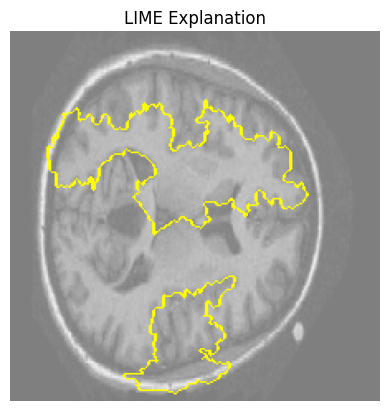

In [27]:
# LIME Explanation
def lime_explanation(model, image, top_labels=5, hide_color=0, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image.astype('double'),
        model.predict,
        top_labels=top_labels,
        hide_color=hide_color,
        num_samples=num_samples
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('LIME Explanation')
    plt.axis('off')
    plt.show()

# Get a sample image for LIME
sample_image, _ = next(test_generator)
lime_explanation(model, sample_image[0])

/home/helal/tf-gpu/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(5, 224, 224, 3))']
  warnings.warn(msg)
2025-05-03 21:01:25.606773: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(10, 224, 224, 3))']
  warnings.warn(msg)
/home/helal/t

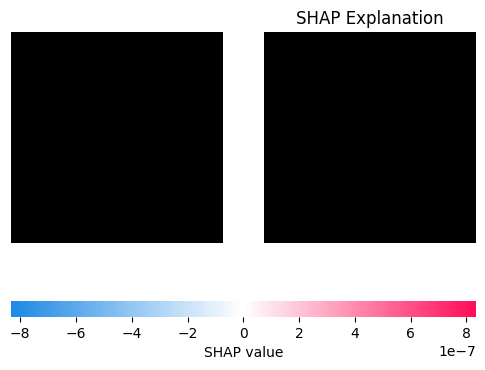

In [28]:
# SHAP Explanation (for a small subset due to computational constraints)
def shap_explanation(model, data_generator, num_samples=10):
    # Get a small subset of images
    background = data_generator[0][0][:num_samples]

    # Create SHAP explainer
    explainer = shap.DeepExplainer(model, background)

    # Explain a test image
    test_image = data_generator[0][0][num_samples:num_samples+1]
    shap_values = explainer.shap_values(test_image)

    # Plot SHAP values
    shap.image_plot(shap_values, -test_image, show=False)
    plt.title('SHAP Explanation')
    plt.show()

shap_explanation(model, test_generator, num_samples=5)